Here we illustrate with a toy example the importance of balanced training

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from face_lib.models.losses import ArcFaceLoss
from face_lib.models.arcface import MetricLearningModel
import seaborn as sns
import pandas as pd
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

### 1. Train arcface on mnist

In [2]:
# 1. Define simple model
class Backbone(nn.Module):
    def __init__(self, num_features=128):
        super(Backbone, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(
            32,
            eps=1e-05,
        )
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(
            64,
            eps=1e-05,
        )
        self.features = nn.BatchNorm1d(num_features, eps=1e-05)
        self.fc1 = nn.Linear(9216, num_features)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.bn2(x)
        x = torch.flatten(x, 1)
        sig_x = x
        x = self.fc1(x)
        x = self.features(x)
        x = F.normalize(x, p=2.0, dim=1)
        output = {
            "feature": x,
            "bottleneck_feature": sig_x,
        }
        return output

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

mnist_ds_train = datasets.MNIST(
    root="/app/datasets/mnist", train=True, download=True, transform=transform
)
mnist_ds_test = datasets.MNIST(
    root="/app/datasets/mnist", train=False, download=True, transform=transform
)

In [4]:
NUM_FEATURES = 2

backbone_model = Backbone(num_features=NUM_FEATURES)
arcface_loss = ArcFaceLoss()

arcface_model = MetricLearningModel(
    backbone_model,
    arcface_loss,
    num_labels=10,
    train_set=mnist_ds_train,
    val_set=mnist_ds_test,
    num_features=NUM_FEATURES,
)

/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


In [5]:
# from pytorch_lightning.loggers import WandbLogger
# from pytorch_lightning.callbacks import ModelCheckpoint
# from pytorch_lightning import Trainer

# MAX_EPOCHS = 200

# # use your own Comet parameters (need to register on https://www.comet.com) or disable the logger
# # you can get api_key in the Quickstart guide section on the website
# wab_logger = WandbLogger(
#     # api_key="agnHNC2vEt7tOxnnxT4LzYf7Y",
#     project="ArcFaceMnist",
# )

# checkpoint_callback = ModelCheckpoint(
#     monitor="val_loss",
#     dirpath="/app/outputs/arcface_mnist/ckpt/",
#     filename="{epoch:02d}-{val_loss:.2f}",
# )

# # initialize trainer, use one GPU for training
# trainer = Trainer(
#     max_epochs=MAX_EPOCHS,
#     default_root_dir="/app/outputs/arcface_mnist",
#     accelerator="gpu",
#     devices=[0],
#     benchmark=True,
#     check_val_every_n_epoch=5,
#     logger=wab_logger,
#     callbacks=[checkpoint_callback],
# )

# # fit the model
# trainer.fit(arcface_model);

100%|██████████| 79/79 [00:03<00:00, 25.84it/s]


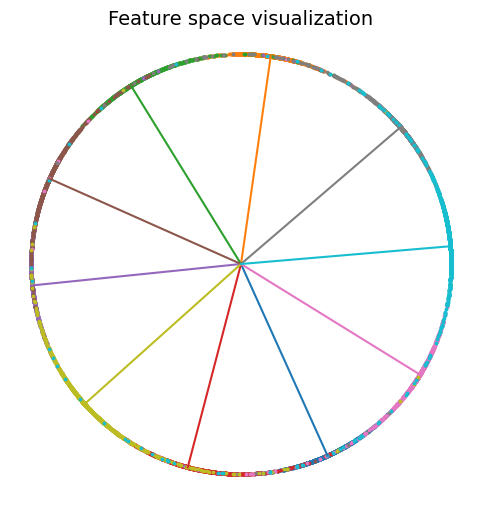

Average distance: 0.0832061342895031


In [6]:
from utils import predict_features, compute_distance_and_visualize

NUM_FEATURES = 2

backbone_model = Backbone(num_features=NUM_FEATURES)
arcface_loss = ArcFaceLoss()

arcface_model = MetricLearningModel(
    backbone_model,
    arcface_loss,
    num_labels=10,
    train_set=mnist_ds_train,
    val_set=mnist_ds_test,
    num_features=NUM_FEATURES,
)
arcface_model = arcface_model.load_from_checkpoint(
    "/app/outputs/arcface_mnist/ckpt/epoch=69-val_loss=1.21.ckpt"
)

predicted_features, image_labels = predict_features(
    arcface_model, arcface_model.val_dataloader()
)

softmax_weights = arcface_model.softmax_weights.detach().cpu()
softmax_weights = F.normalize(softmax_weights, dim=1).numpy()

dists = compute_distance_and_visualize(
    predicted_features, image_labels, softmax_weights, num_features=NUM_FEATURES
)

print(f"Average distance: {np.mean(dists)}")

#### Cosine similarity distribution

In [7]:
from torch.utils.data import DataLoader
from utils import predict_features, compute_distance_and_visualize

train_dl = DataLoader(
    mnist_ds_train,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=32,
)
test_dl = DataLoader(
    mnist_ds_test,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=32,
)

In [8]:
# predicted_train_features, train_labels = predict_features(
#     arcface_model, train_dl
# )
# softmax_weights = F.normalize(arcface_model.softmax_weights, dim=1)
# wc = softmax_weights[train_labels, :].detach().cpu()
# predicted_train_features = torch.tensor(predicted_train_features)
# cosine_sim_train = torch.sum(predicted_train_features * wc, dim=1, keepdim=True)
# cosine_sim_train = cosine_sim_train[:, 0].numpy()
# np.save("mnist_train_cosine_sim.npy", cosine_sim_train)

# predicted_test_features, test_labels = predict_features(
#     arcface_model, test_dl
# )
# predicted_test_features = torch.tensor(predicted_test_features)
# wc_test = softmax_weights[test_labels, :].detach().cpu()
# cosine_sim_test = torch.sum(predicted_test_features * wc_test, dim=1, keepdim=True)
# cosine_sim_test = cosine_sim_test[:, 0].numpy()
# np.save("mnist_test_cosine_sim.npy", cosine_sim_test)

In [9]:
cosine_sim_train = np.load("outputs/mnist_train_cosine_sim.npy")
cosine_sim_test = np.load("outputs/mnist_test_cosine_sim.npy")
batch_size = 400
rng = np.random.default_rng(776)

/tmp/ipykernel_351721/115870113.py:3: RuntimeWarning: invalid value encountered in arccos
  "train": (np.arccos(cosine_sim_train) / (2 * np.pi)) * 360,


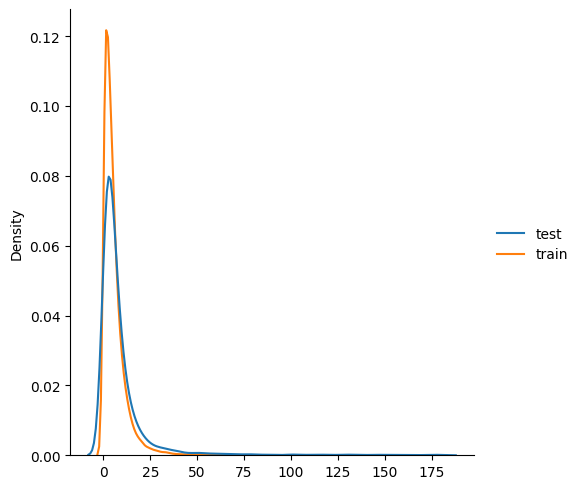

In [10]:
data = {
    "test": (np.arccos(cosine_sim_test) / (2 * np.pi)) * 360,
    "train": (np.arccos(cosine_sim_train) / (2 * np.pi)) * 360,
}
sns.displot(
    data,
    kind="kde",
    log_scale=False,
    common_norm=False,
)

In [11]:
np.sum((np.arccos(cosine_sim_train) / (2 * np.pi)) * 360 > 18), len(cosine_sim_train)

/tmp/ipykernel_351721/2342528981.py:1: RuntimeWarning: invalid value encountered in arccos
  np.sum((np.arccos(cosine_sim_train) / (2 * np.pi)) * 360 > 18), len(cosine_sim_train)


(2714, 60000)

In [12]:
# dists = compute_distance_and_visualize(
#     predicted_train_features, train_labels, softmax_weights, num_features=NUM_FEATURES
# )

#### Verification protocol

In [14]:
# predicted_test_features, test_labels = predict_features(arcface_model, test_dl)
# first_template = []
# second_template = []
# is_positive = []
# for i in tqdm(range(len(mnist_ds_test))):
#     for j in range(len(mnist_ds_test)):
#         if i <= j: continue
#         first_template.append(i)
#         second_template.append(j)
#         is_positive.append(test_labels[i] == test_labels[j])
# first_template = np.array(first_template)
# second_template = np.array(second_template)
# is_positive = np.array(is_positive)
# pairs = pd.DataFrame(
#     {
#         "first_template": first_template,
#         "second_template": second_template,
#         "is_positive": is_positive,
#     }
# )
# pairs.to_csv("pairs.csv", index=False)

In [15]:
# pairs = pd.read_csv("outputs/pairs.csv")
# def distance_function(X_1, X_2):
#     return np.sum(X_1 * X_2, axis=1)


# p1 = pairs["first_template"].values
# p2 = pairs["second_template"].values

# batch_size = 10000
# steps = int(np.ceil(len(p1) / batch_size))
# scores = []
# for id in tqdm(range(steps), "Verification"):
#     feat1 = predicted_test_features[p1[id * batch_size : (id + 1) * batch_size]]
#     feat2 = predicted_test_features[p2[id * batch_size : (id + 1) * batch_size]]
#     scores.extend(distance_function(feat1, feat2))
# scores = np.array(scores)

In [16]:
# from evaluation.visualize import draw_score_distr_plot

# is_positive = pairs["is_positive"].values

# true_match_scores = scores[is_positive]
# wrong_match_scores = scores[is_positive == 0]
# scores_distr = {
#     "Истинная пара": true_match_scores,
#     "Ложная пара": wrong_match_scores,
# }
# draw_score_distr_plot(
#     scores_distr=scores_distr,
#     positive_pair_name="Истинная пара",
#     negative_pair_name="Ложная пара",
# )

#### TAR@FAR Curve

In [17]:
# from sklearn.metrics import auc
# import matplotlib.pyplot as plt
# fars = [10**ii for ii in np.arange(-6, 0, 4 / 100)] + [1]
# threshes, recalls = [], []
# wrong_match_scores_sorted = np.sort(wrong_match_scores)[::-1]
# for far in fars:
#     thresh = wrong_match_scores_sorted[
#         max(int((wrong_match_scores_sorted.shape[0]) * far) - 1, 0)
#     ]
#     recall = np.sum(true_match_scores > thresh) / true_match_scores.shape[0]
#     threshes.append(thresh)
#     recalls.append(recall)

# sns.set_style("whitegrid")
# fig = plt.figure()

# auc_value = auc(fars, recalls)
# label = "%s (AUC = %0.4f%%), tar %0.4f at far %.1E" % (
#     "Косинусное расстояние",
#     auc_value * 100,
#     recalls[0],
#     fars[0],
# )
# plt.plot(fars, recalls, lw=1, label=label)

# plt.xlabel("False Acceptance Rate")
# plt.xlim([fars[0], 1])
# plt.xscale("log")
# plt.ylabel("True Acceptance Rate (%)")
# plt.ylim([0, 1])

# # plt.grid(linestyle="--", linewidth=1)
# plt.legend(fontsize="x-small")
# # plt.tight_layout()
# plt.show()

### 2. Train scf model

In [18]:
train_dl = DataLoader(
    mnist_ds_train,
    batch_size=128,
    shuffle=True,
    drop_last=False,
    num_workers=32,
)
test_dl = DataLoader(
    mnist_ds_test,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=32,
)

In [26]:
from face_lib.models.scf import SphereConfidenceFace
from face_lib.models.heads import SCFHead
from face_lib.models.losses import KLDiracVMF

NUM_FEATURES = 2
radius = 1
optimizer_params = {
    "optimizer_path": "torch.optim",
    "optimizer_name": "AdamW",
    "params": {"lr": 3e-5, "weight_decay": 5e-4},
}
scheduler_params = {
    "scheduler": "StepLR",
    "params": {"step_size": 2, "gamma": 0.5},
    "interval": "step",
    "frequency": 1,
}
backbone_model = Backbone(num_features=NUM_FEATURES)
arcface_loss = ArcFaceLoss()

arcface_model = MetricLearningModel(
    backbone_model,
    arcface_loss,
    num_labels=10,
    train_set=mnist_ds_train,
    val_set=mnist_ds_test,
    num_features=NUM_FEATURES,
)
arcface_model = arcface_model.load_from_checkpoint(
    "/app/outputs/arcface_mnist/ckpt/epoch=69-val_loss=1.21.ckpt"
)
backbone = arcface_model.backbone
head = SCFHead(convf_dim=9216, latent_vector_size=32)
scf_loss = KLDiracVMF(z_dim=2, radius=radius)
scf_model = SphereConfidenceFace(
    backbone=backbone,
    head=head,
    scf_loss=scf_loss,
    optimizer_params=optimizer_params,
    scheduler_params=scheduler_params,
    softmax_weights=arcface_model,
    permute_batch=False,
)

/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


In [27]:
# torch.save(softmax_weights, 'outputs/softmax_weights.pt')

In [29]:
import pytorch_lightning
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer

MAX_EPOCHS = 200

wab_logger = WandbLogger(
    project="ArcFaceMnist",
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/app/outputs/scf_mnist/ckpt/",
    filename="{epoch:02d}-{val_loss:.2f}",
)
lr_callback = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval="step")

# initialize trainer, use one GPU for training
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    default_root_dir="/app/outputs/scf_mnist/ckpt/",
    accelerator="gpu",
    devices=[0],
    benchmark=True,
    check_val_every_n_epoch=5,
    logger=wab_logger,
    callbacks=[checkpoint_callback, lr_callback],
)

# fit the model
trainer.fit(scf_model, train_dl);

/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precis

Epoch 6:  26%|██▌       | 123/469 [00:02<00:07, 45.90it/s, v_num=g5s1, train_loss=1.380]